In [ ]:
# # Associate Ca2+ signal with spindles for each session & subsessions using crossregistration

#######################################################################################
                            # Define Experiment type #
#######################################################################################

DrugExperiment=0 # 0 if Baseline Experiment / 1 if CGP Experiment

saveexcel=1

AHmethod=0 # 0 if using the method of Aurelie B (2025) / 1 if using the method of Audrey Hay (2025)

AnalysisID='_likeAH' if AHmethod else '_pynapple' # '_pynapple' if using the method of Aurelie Hay (2025) / '_minian' if using the method of Audrey Hay (2025)
suffix='_Allcouplings'

CTX=['S1', 'PFC', 'S1PFC']
Coupling=['', 'UnCoupled', 'PreCoupled', 'PostCoupled', 'PrePostCoupled']
dir = "//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/Analysed2025_AB/"

drugs=['baseline', 'CGP'] if DrugExperiment else ['baseline']

#######################################################################################
                                # Load packages #
#######################################################################################

import os
import quantities as pq
import numpy as np
import math 
import neo
import json
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
from scipy.interpolate import interp2d
from scipy.signal import find_peaks
from scipy.stats import zscore
import pickle
import os
from scipy.interpolate import griddata
import logging
import sys 
import shutil
from bisect import bisect_left
from ast import literal_eval
from scipy import interpolate
import time

from itertools import groupby
from ephyviewer import mkQApp, MainViewer, TraceViewer
from IPython.display import display
from ipyfilechooser import FileChooser
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

minian_path = os.path.join(os.path.abspath('.'),'minian')
print("The folder used for minian procedures is : {}".format(minian_path))
sys.path.append(minian_path)

#######################################################################################
                                # Define functions #
#######################################################################################

def is_between(myList, starttime, endtime):
    IsTrue=False
    for ind in range(len(myList)):
        if starttime <= myList[ind] <= endtime:
            IsTrue=True
    return IsTrue

def is_overlapping(starttime, endtime, starttimeList, endtimeList):
    IsTrue='False'
    for ind in starttimeList.index: #range(len(starttimeList)):
        if starttime<=starttimeList[ind] and starttimeList[ind]<=endtime: # event n°2 begins after the start n°1               
            if (endtime-starttimeList[ind])>=int(0.5*(endtime-starttime)): # overlapp > to 50% of the duration of the event n°1
                IsTrue='True'
                break                
        elif starttime<=endtimeList[ind] and endtimeList[ind]<=endtime: # event n°2 ends before the end n°1 
            if (endtimeList[ind]-starttime)>=int(0.5*(endtime-starttime)): # overlapp > to 50% of the duration of the event n°1
                IsTrue='True'
                break
    return IsTrue, ind

def find_session_folders(root_path):
    sessions = []
    sessions_path=[]
    # Iterate through items in the root_path
    for item in os.listdir(root_path):
        item_path = os.path.join(root_path, item)
        if os.path.isdir(item_path):
            # Check if the directory name contains "session"
            if "session" in item:
                sessions.append(item)
                sessions_path.append(item_path)
            else:
                # Check the subdirectories of the current directory
                for sub_item in os.listdir(item_path):
                    sub_item_path = os.path.join(item_path, sub_item)
                    if os.path.isdir(sub_item_path) and "session" in sub_item:
                        sessions.append(sub_item)
                        sessions_path.append(sub_item_path)
                        
    return sessions, sessions_path

def restriction_parameter(All_Spindle):
    nb_spindle = All_Spindle.shape[0]
    listtodrop = []
    for tt in range(nb_spindle-1):
        # merge spdl that starts within a spdl
        if(All_Spindle['end time'][tt]>All_Spindle['start time'][tt + 1]):
            if(All_Spindle['Duration'][tt]<All_Spindle['Duration'][tt + 1]):
                if(All_Spindle['start time'][tt]<All_Spindle['start time'][tt + 1]):
                    All_Spindle['start time'][tt+1] = All_Spindle['start time'][tt]
                    listtodrop.append(tt)
                else:
                    listtodrop.append(tt)
            if(All_Spindle['Duration'][tt]>All_Spindle['Duration'][tt + 1]):
                if(All_Spindle['end time'][tt]<All_Spindle['end time'][tt + 1]):
                    All_Spindle['end time'][tt] = All_Spindle['end time'][tt + 1]
                    listtodrop.append(tt+1)
                else:
                    listtodrop.append(tt+1)
    """
    for tt in range(nb_spindle-1):
        # merge spdls that are 200ms apart
        if((All_Spindle['start time'][tt + 1] - All_Spindle['end time'][tt])<200):
            if((All_Spindle['Duration'][tt])<All_Spindle['Duration'][tt + 1]): #first spdl longer so remove/merge the second one
                All_Spindle['start time'][tt + 1] = min(All_Spindle['start time'][tt], All_Spindle['start time'][tt+1])
                All_Spindle['end time'][tt+ 1] = max(All_Spindle['end time'][tt + 1], All_Spindle['end time'][tt])
                listtodrop.append(tt)
            if((All_Spindle['Duration'][tt+1])<All_Spindle['Duration'][tt]): #second spdl longer so remove/merge the first one
                All_Spindle['start time'][tt] = min(All_Spindle['start time'][tt], All_Spindle['start time'][tt+1])
                All_Spindle['end time'][tt] = max(All_Spindle['end time'][tt + 1], All_Spindle['end time'][tt])
                listtodrop.append(tt+1)
    """
    for tt in range(nb_spindle):
        #Update duration because of the merging
        All_Spindle['Duration'][tt]=All_Spindle['end time'][tt]-All_Spindle['start time'][tt]

    for tt in range(nb_spindle): #All_Spindle.index:
        #Remove Spdl that last less than 500ms
        if (All_Spindle['Duration'][tt]<500):
            listtodrop.append(tt)        
    
    All_Spindle = All_Spindle.drop(listtodrop) 
    All_Spindle = All_Spindle.reset_index(drop=True)
    return All_Spindle

#######################################################################################
                # Load sleep score and Ca2+ time series numpy arrays #
#######################################################################################

all_expe_types=['baseline', 'preCGP', 'postCGP'] if DrugExperiment else ['baseline', 'preCGP']

# Get the current date and time
FolderNameSave=str(datetime.now())[:19]
FolderNameSave = FolderNameSave.replace(" ", "_").replace(".", "_").replace(":", "_")

destination_folder= f"//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/Analysed2025_AB/_CGP_analysis/Osc_{FolderNameSave}{suffix}{AnalysisID}" if DrugExperiment else f"//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/Analysed2025_AB/_baseline_analysis/Osc_{FolderNameSave}{suffix}{AnalysisID}"
os.makedirs(destination_folder)
folder_to_save=Path(destination_folder)

# Copy the script file to the destination folder
source_script = "C:/Users/Manip2/SCRIPTS/CodePythonAudrey/CodePythonAurelie/HayLabAnalysis/python/OE_4_OscCoupling.ipynb"
destination_file_path = f"{destination_folder}/OE_4_OscCoupling.txt"
shutil.copy(source_script, destination_file_path)
     

for dpath in Path(dir).glob('**/mappingsAB.pkl'):
    
    mappfile = open(dpath.parents[0]/ f'mappingsAB.pkl', 'rb')
    mapping = pickle.load(mappfile)
    mapping_sess = mapping['session']   

    mice = dpath.parents[0].parts[-1]
    NeuronType = dpath.parents[1].parts[-1]
    
    print(f"####################################################################################")
    print(f"################################### {mice} ####################################")
    print(f"####################################################################################")

    subsessions = []
    dict_SWRprop = {}
    dict_Spindleprop = {}
    dict_Path={}

    AllSWRPFC=[]
    AllSWRS1=[]
    AllSpdlS1=[]
    AllSpdlPFC=[]


    minian_folders = [f for f in dpath.parents[0].rglob('minian') if f.is_dir()]

    for minianpath in minian_folders: # for each minian folders found in this mouse

        if any(p in all_expe_types for p in minianpath.parts): # have to be to the expe_types

            start = time.time()
            
            session=minianpath.parents[0].name if len(minianpath.parts)==12 else minianpath.parents[1].name.split("_")[-1]
            session_path=minianpath.parents[2] if len(minianpath.parts)==12 else minianpath.parents[1]
            expe_type=minianpath.parents[3].name if len(minianpath.parts)==12 else minianpath.parents[2].name

            drug='CGP' if expe_type == 'postCGP' else 'baseline'
            dict_Path[session] = session_path
            
            SWRlist= pd.read_csv(session_path / f'OpenEphys/SWRproperties.csv' ) if AHmethod else pd.read_csv(session_path / f'OpenEphys/SWR_detection.csv' ) 
            SWRlist['toKeep'] = 'True' # SWRlist['toKeep'].astype(str)
            SWRprop  =SWRlist[SWRlist['toKeep'].isin(['VRAI', 'True'])]


            Spdllist = pd.read_csv(session_path / f'OpenEphys/Spindleproperties_PFC.csv') if AHmethod else pd.read_csv(session_path / f'OpenEphys/SpindlesPFC_detection.csv' ) 
            Spdllist['toKeep'] = 'True' # Spdllist['toKeep'].astype(str)
            PFClist  = Spdllist[Spdllist['toKeep'].isin(['VRAI', 'True'])]


            Spdllist = pd.read_csv(session_path / f'OpenEphys/Spindleproperties_S1.csv') if AHmethod else pd.read_csv(session_path / f'OpenEphys/SpindlesS1_detection.csv' ) 
            Spdllist['toKeep'] = 'True' # Spdllist['toKeep'].astype(str)
            S1list  = Spdllist[Spdllist['toKeep'].isin(['VRAI', 'True'])]
            


            if DrugExperiment: 
                PFClist['toKeep'] = PFClist['toKeep'].astype(str)
                PFClist  = PFClist[PFClist['toKeep'].isin(['VRAI', 'True'])]
            else: 
                PFClist['toKeep'] ='VRAI'
            PFClist['CTX']='PFC'
            PFClist['StartingLoc']='PFC'
            PFClist = PFClist.reset_index(drop=True)
            NewPFClist=restriction_parameter(PFClist)                    
            NewPFClist = NewPFClist[NewPFClist['toKeep'].isin(['True', 'VRAI'])]
            NewPFClist = NewPFClist.sort_values(by='start time')
            NewPFClist = NewPFClist.reset_index(drop=True)


            if DrugExperiment: 
                S1list['toKeep'] = S1list['toKeep'].astype(str)
                S1list  = S1list[S1list['toKeep'].isin(['VRAI', 'True'])]
            else: 
                S1list['toKeep'] ='VRAI'
            S1list['CTX']='S1'
            S1list['StartingLoc']='S1'
            S1list = S1list.reset_index(drop=True)
            NewS1list=restriction_parameter(S1list)
            NewS1list = NewS1list[NewS1list['toKeep'].isin(['True', 'VRAI'])]
            NewS1list = NewS1list.sort_values(by='start time')
            NewS1list = NewS1list.reset_index(drop=True)


            #Aurelie's script
            for spdl1 in NewS1list.index : # range(len(Spdllist)) :
                start1=NewS1list["start time"][spdl1]
                end1=NewS1list["end time"][spdl1]
                start2list=NewPFClist["start time"]
                if len(start2list)>0:
                    distancePFCspdl=min(start2list-start1, key=abs)      
                    my_list=start2list-start1 
                    filtered_listSpdl = [value for value in my_list if -5000 <= value <= 5000] # more or less 5 sec from the spdl
                    AllSpdlS1+=filtered_listSpdl
                else: 
                    distancePFCspdl=None        
                start2list=SWRprop["start time"]
                if len(start2list)>0:
                    distancSWR=min(start2list-start1, key=abs)
                    my_list=start2list-start1 
                    filtered_listSWR = [value for value in my_list if -5000 <= value <= 5000] # more or less 5 sec from the spdl
                    AllSWRS1+=filtered_listSWR
                else: 
                    distancSWR=None

            for spdl1 in NewPFClist.index : # range(len(Spdllist)) :
                start1=NewPFClist["start time"][spdl1]
                end1=NewPFClist["end time"][spdl1]
                
                start2list=NewS1list["start time"]
                if len(start2list)>0:
                    distanceS1spdl=min(start2list-start1, key=abs)  
                    my_list=start2list-start1 
                    filtered_listSpdl = [value for value in my_list if -5000 <= value <= 5000] # more or less 5 sec from the spdl
                    AllSpdlPFC+=filtered_listSpdl 
                else: 
                    distanceS1spdl=None             
                
                start2list=SWRprop["start time"]
                if len(start2list)>0:
                    distancSWR=min(start2list-start1, key=abs)
                    my_list=start2list-start1 
                    filtered_listSWR = [value for value in my_list if -5000 <= value <= 5000] # more or less 5 sec from the spdl
                    AllSWRPFC+=filtered_listSWR
                else: 
                    distancSWR=None

    #######################################################################################
                            # Save Spindles & SWR & DS analysis #
    #######################################################################################
    if saveexcel: 

        filenameOut = folder_to_save / f'SpdlPFC_couplinglist_{mice}.xlsx'
        writer = pd.ExcelWriter(filenameOut)
        df = pd.DataFrame(AllSpdlPFC, columns=['S1occurence'])
        df.to_excel(writer)
        writer.close()

        filenameOut = folder_to_save / f'SpdlS1_couplinglist_{mice}.xlsx'
        writer = pd.ExcelWriter(filenameOut)
        df = pd.DataFrame(AllSpdlS1, columns=['PFCoccurence'])
        df.to_excel(writer)
        writer.close()
        
        filenameOut = folder_to_save / f'SWR_PFCcouplinglist_{mice}.xlsx'
        writer = pd.ExcelWriter(filenameOut)
        df = pd.DataFrame(AllSWRPFC, columns=['SWRoccurence'])
        df.to_excel(writer)
        writer.close()

        filenameOut = folder_to_save / f'SWR_S1couplinglist_{mice}.xlsx'
        writer = pd.ExcelWriter(filenameOut)
        df = pd.DataFrame(AllSWRS1, columns=['SWRoccurence'])
        df.to_excel(writer)
        writer.close()
    
    filenameOut = folder_to_save / f'SpdlPFC_couplinglist_{mice}.pkl'
    with open(filenameOut, 'wb') as pickle_file:
        pickle.dump(AllSpdlPFC, pickle_file)          
        
    filenameOut = folder_to_save / f'SpdlS1_couplinglist_{mice}.pkl'
    with open(filenameOut, 'wb') as pickle_file:
        pickle.dump(AllSpdlS1, pickle_file)   

    filenameOut = folder_to_save / f'SWR_PFCcouplinglist_{mice}.pkl'
    with open(filenameOut, 'wb') as pickle_file:
        pickle.dump(AllSWRPFC, pickle_file)           
        
    filenameOut = folder_to_save / f'SWR_S1couplinglist_{mice}.pkl'
    with open(filenameOut, 'wb') as pickle_file:
        pickle.dump(AllSWRS1, pickle_file)   

The folder used for minian procedures is : c:\Users\Manip2\SCRIPTS\CodePythonAudrey\CodePythonAurelie\HayLabAnalysis\python\minian
####################################################################################
################################### BlackLines ####################################
####################################################################################
####################################################################################
################################### BlueLines ####################################
####################################################################################
####################################################################################
################################### GreenDots ####################################
####################################################################################
####################################################################################
########################

In [139]:
# Stats on Ca2+ imaging with miniscope and Osc
#######################################################################################
                            # Define Experiment type #
#######################################################################################

DrugExperiment=0 # 1 if CGP Experiment, 0 if Baseline Experiment

suffix='_AllcouplingsAVG'

Local=1

choosed_folder1='Osc_2025-05-19_16_47_26_Allcouplings_pynapple' # for Baseline Expe
choosed_folder2='Osc_2025-05-19_16_47_26_Allcouplings_pynapple' # for CGP Expe


choosed_folder='Osc_2025-05-19_16_47_26_Allcouplings_pynapple' if DrugExperiment else 'Osc_2025-05-19_16_47_26_Allcouplings_pynapple'


def column_with_max_single_per_row(row):
    max_val = row.max()  # Find the max value in the row
    max_columns = row == max_val  # Boolean Series of columns with max value
    
    if max_columns.sum() > 1:
        return 'NoPref'  # More than one column has the max value
    else:
        return max_columns.idxmax()  # Return the name of the column with max value

def divide_keys(data):
    it=list(data.keys())[0]
    d=data[it]
    data[it]=d.replace(0, np.nan)
    for sheet in list(data.keys())[1:]: 
        data[sheet].div(data[it][sheet], axis=0)
    del data[it]
    return data    

########################################################################
        # SCRIPT 27AB_GrandAverages&Stats_for_Osc
########################################################################
all_expe_types=['baseline', 'preCGP', 'postCGP'] if DrugExperiment else ['baseline', 'preCGP']

# Get the current date and time
FolderNameSave=str(datetime.now())[:19]
FolderNameSave = FolderNameSave.replace(" ", "_").replace(".", "_").replace(":", "_")

destination_folder= f"//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/Analysed2025_AB/_CGP_analysis/Osc_{FolderNameSave}{suffix}{AnalysisID}" if DrugExperiment else f"//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/Analysed2025_AB/_baseline_analysis/Osc_{FolderNameSave}{suffix}{AnalysisID}"
os.makedirs(destination_folder)
folder_to_save=Path(destination_folder)

# Copy the script file to the destination folder
source_script = "C:/Users/Manip2/SCRIPTS/CodePythonAudrey/CodePythonAurelie/HayLabAnalysis/python/OE_4_OscCoupling.ipynb"
destination_file_path = f"{destination_folder}/OE_4_OscCoupling.txt"
shutil.copy(source_script, destination_file_path)
     

# Specify the directory containing the Excel files
InitialDirectory1 =f"//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/Analysed2025_AB/_baseline_analysis/" 
directory1= f'{InitialDirectory1}/{choosed_folder1}'
InitialDirectory2 = "//10.69.168.1/crnldata/forgetting/Aurelie/GaelleData/CGP/AB_Analysis" 
directory2= f'{InitialDirectory2}/{choosed_folder2}'

Drugs= ['Baseline', 'CGP'] if DrugExperiment else ['Baseline']

bins = int((5000 - -5000) / 100) 
bins = 50

GrandPSTH_PFC_S1spdl=[]
GrandPSTH_S1_PFCspdl=[]
GrandPSTH_SWR_S1spdl=[]
GrandPSTH_SWR_PFCspdl=[]

###########################################################################
                            ##### GLOBAL #####
###########################################################################
dfs = []

nametofind=f'SpdlS1_'

# Recursively traverse the directory structure
#for directory in [directory1, directory2]: #both Baseline & CGP experiments 
for directory in [directory1]: #both Baseline & CGP experiments 
    for root, _, files in os.walk(directory):
        for filename in files:
            # Check if the file is an Excel file and contains the specified name
            if filename.endswith('.pkl') and nametofind in filename:
                # Construct the full path to the file
                filepath = os.path.join(root, filename)
                # Read the file and append it to the list
                with open(filepath, 'rb') as pickle_file:
                    df = pickle.load(pickle_file)
                dfs+=df
                PSTH,binedges=np.histogram(df, bins=bins)
                #PSTH = (PSTH / len(df)) * 100
                GrandPSTH_PFC_S1spdl.append(PSTH)


###########################################################################
                            ##### GLOBAL #####
###########################################################################
dfs = []

nametofind=f'SpdlPFC_'

# Recursively traverse the directory structure
#for directory in [directory1, directory2]: #both Baseline & CGP experiments 
for directory in [directory1]: #both Baseline & CGP experiments 
    for root, _, files in os.walk(directory):
        for filename in files:
            # Check if the file is an Excel file and contains the specified name
            if filename.endswith('.pkl') and nametofind in filename:
                # Construct the full path to the file
                filepath = os.path.join(root, filename)
                # Read the file and append it to the list
                with open(filepath, 'rb') as pickle_file:
                    df = pickle.load(pickle_file)
                dfs+=df
                PSTH,binedges=np.histogram(df, bins=bins)
                #PSTH = (PSTH / len(df)) * 100
                GrandPSTH_S1_PFCspdl.append(PSTH/sum(PSTH))

###########################################################################
                            ##### GLOBAL #####
###########################################################################

nametofind=f'SWR_S1'
dfs = []

# Recursively traverse the directory structure
for directory in [directory1]: #both Baseline & CGP experiments 
    for root, _, files in os.walk(directory):
        for filename in files:
            # Check if the file is an Excel file and contains the specified name
            if filename.endswith('.pkl') and nametofind in filename:
                # Construct the full path to the file
                filepath = os.path.join(root, filename)
                # Read the file and append it to the list
                with open(filepath, 'rb') as pickle_file:
                    df = pickle.load(pickle_file)
                dfs+=df
                PSTH,binedges=np.histogram(df, bins=bins)
                #PSTH = (PSTH / len(df)) * 100
                GrandPSTH_SWR_S1spdl.append(PSTH/sum(PSTH))


nametofind=f'SWR_PFC'
dfs = []

# Recursively traverse the directory structure
for directory in [directory1]: #both Baseline & CGP experiments 
    for root, _, files in os.walk(directory):
        for filename in files:
            # Check if the file is an Excel file and contains the specified name
            if filename.endswith('.pkl') and nametofind in filename:
                # Construct the full path to the file
                filepath = os.path.join(root, filename)
                # Read the file and append it to the list
                with open(filepath, 'rb') as pickle_file:
                    df = pickle.load(pickle_file)
                dfs+=df
                PSTH,binedges=np.histogram(df, bins=bins)
                #PSTH = (PSTH / len(df)) * 100
                GrandPSTH_SWR_PFCspdl.append(PSTH/sum(PSTH))
                print(filename)

SWR_PFCcouplinglist_BlackLines.pkl
SWR_PFCcouplinglist_BlueLines.pkl
SWR_PFCcouplinglist_GreenDots.pkl
SWR_PFCcouplinglist_GreenLines.pkl
SWR_PFCcouplinglist_PurpleSquare.pkl
SWR_PFCcouplinglist_RedLines.pkl
SWR_PFCcouplinglist_ThreeBlueCrosses.pkl
SWR_PFCcouplinglist_ThreeColDots.pkl


In [37]:
%matplotlib widget

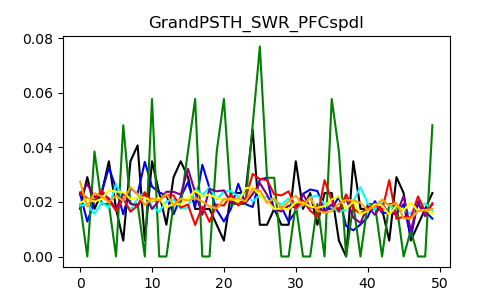

In [140]:
plt.close()
plt.figure(figsize=(5, 3))
plt.plot(GrandPSTH_SWR_PFCspdl[0], color='black') #BlackLines
plt.plot(GrandPSTH_SWR_PFCspdl[1], color='blue') #BlueLines
plt.plot(GrandPSTH_SWR_PFCspdl[2], color='Green') #GreenDots
plt.plot(GrandPSTH_SWR_PFCspdl[3], color='Cyan') #GreenLines
plt.plot(GrandPSTH_SWR_PFCspdl[4], color='Purple') #PurpleSquare
plt.plot(GrandPSTH_SWR_PFCspdl[5], color='Red') #RedLines
plt.plot(GrandPSTH_SWR_PFCspdl[6], color='Yellow') #ThreeBlueCrosses
plt.plot(GrandPSTH_SWR_PFCspdl[7], color='Orange') #ThreeColDots
plt.title('GrandPSTH_SWR_PFCspdl')
plt.show()

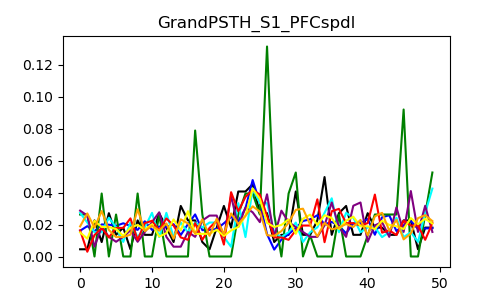

In [141]:
plt.close()
plt.figure(figsize=(5, 3))
plt.plot(GrandPSTH_S1_PFCspdl[0], color='black')
plt.plot(GrandPSTH_S1_PFCspdl[1], color='blue')
plt.plot(GrandPSTH_S1_PFCspdl[2], color='Green')
plt.plot(GrandPSTH_S1_PFCspdl[3], color='Cyan')
plt.plot(GrandPSTH_S1_PFCspdl[4], color='Purple')
plt.plot(GrandPSTH_S1_PFCspdl[5], color='Red')
plt.plot(GrandPSTH_S1_PFCspdl[6], color='Yellow')
plt.plot(GrandPSTH_S1_PFCspdl[7], color='Orange')
plt.title('GrandPSTH_S1_PFCspdl')
plt.show()

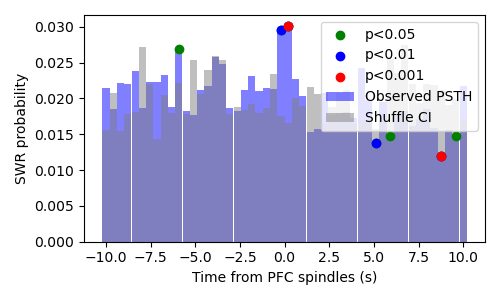

In [177]:
import numpy as np
import matplotlib.pyplot as plt

plt.close()
plt.figure(figsize=(5, 3))

# Simulate spike data
n_bins = bins
spike_counts=GrandPSTH_SWR_PFCspdl

# Compute the observed PSTH
observed_psth = np.mean(spike_counts, axis=0)

# Monte Carlo parameters
n_permutations = 5000
shuffled_psths = []

# Shuffle data and compute shuffled PSTHs
for _ in range(n_permutations):
    shuffled_counts = np.apply_along_axis(np.random.permutation, 1, spike_counts)
    shuffled_psth = shuffled_counts.mean(axis=0)
    shuffled_psths.append(shuffled_psth)

shuffled_psths = np.array(shuffled_psths)

# Compute significance (e.g., p < 0.05)
alpha = 0.05
lower_bound = np.percentile(shuffled_psths, alpha / 2 * 100, axis=0)
upper_bound = np.percentile(shuffled_psths, (1 - alpha / 2) * 100, axis=0)
significant_bins05 = (observed_psth < lower_bound) | (observed_psth > upper_bound)

alpha = 0.01
lower_bound = np.percentile(shuffled_psths, alpha / 2 * 100, axis=0)
upper_bound = np.percentile(shuffled_psths, (1 - alpha / 2) * 100, axis=0)
significant_bins01 = (observed_psth < lower_bound) | (observed_psth > upper_bound)

alpha = 0.001
lower_bound = np.percentile(shuffled_psths, alpha / 2 * 100, axis=0)
upper_bound = np.percentile(shuffled_psths, (1 - alpha / 2) * 100, axis=0)
significant_bins001 = (observed_psth < lower_bound) | (observed_psth > upper_bound)


# Plot results
time_bins = np.linspace(-10, 10, n_bins)
plt.bar(time_bins, observed_psth, label='Observed PSTH', color='blue', width=0.4, alpha=0.5)
plt.bar(time_bins, shuffled_psths[0], color='gray', label='Shuffle CI', width=0.4, alpha=0.5)

plt.scatter(
    time_bins[significant_bins05],
    observed_psth[significant_bins05],
    color='green',
    label='p<0.05',
)
plt.scatter(
    time_bins[significant_bins01],
    observed_psth[significant_bins01],
    color='blue',
    label='p<0.01',
)
plt.scatter(
    time_bins[significant_bins001],
    observed_psth[significant_bins001],
    color='red',
    label='p<0.001',
)

plt.xlabel('Time from PFC spindles (s)')
plt.ylabel('SWR probability')
plt.legend()
plt.tight_layout()
plt.savefig(f'C:/Users/Manip2/Documents/Manuscripts/Figures_PNASreviews/Figure4_revised/ProbaSWRPFCSpdl.svg', format='svg', bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()


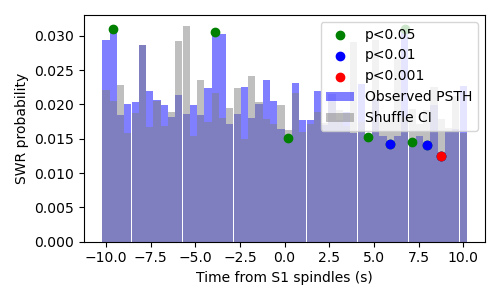

In [176]:
import numpy as np
import matplotlib.pyplot as plt

plt.close()
plt.figure(figsize=(5, 3))

# Simulate spike data
n_bins = bins
spike_counts=GrandPSTH_SWR_S1spdl

# Compute the observed PSTH
observed_psth = np.mean(spike_counts, axis=0)

# Monte Carlo parameters
n_permutations = 5000
shuffled_psths = []

# Shuffle data and compute shuffled PSTHs
for _ in range(n_permutations):
    shuffled_counts = np.apply_along_axis(np.random.permutation, 1, spike_counts)
    shuffled_psth = shuffled_counts.mean(axis=0)
    shuffled_psths.append(shuffled_psth)

shuffled_psths = np.array(shuffled_psths)

# Compute significance (e.g., p < 0.05)
alpha = 0.05
lower_bound = np.percentile(shuffled_psths, alpha / 2 * 100, axis=0)
upper_bound = np.percentile(shuffled_psths, (1 - alpha / 2) * 100, axis=0)
significant_bins05 = (observed_psth < lower_bound) | (observed_psth > upper_bound)

alpha = 0.01
lower_bound = np.percentile(shuffled_psths, alpha / 2 * 100, axis=0)
upper_bound = np.percentile(shuffled_psths, (1 - alpha / 2) * 100, axis=0)
significant_bins01 = (observed_psth < lower_bound) | (observed_psth > upper_bound)

alpha = 0.001
lower_bound = np.percentile(shuffled_psths, alpha / 2 * 100, axis=0)
upper_bound = np.percentile(shuffled_psths, (1 - alpha / 2) * 100, axis=0)
significant_bins001 = (observed_psth < lower_bound) | (observed_psth > upper_bound)


# Plot results
time_bins = np.linspace(-10, 10, n_bins)
plt.bar(time_bins, observed_psth, label='Observed PSTH', color='blue', width=0.4, alpha=0.5)
plt.bar(time_bins, shuffled_psths[0], color='gray', label='Shuffle CI', width=0.4, alpha=0.5)

plt.scatter(
    time_bins[significant_bins05],
    observed_psth[significant_bins05],
    color='green',
    label='p<0.05',
)
plt.scatter(
    time_bins[significant_bins01],
    observed_psth[significant_bins01],
    color='blue',
    label='p<0.01',
)
plt.scatter(
    time_bins[significant_bins001],
    observed_psth[significant_bins001],
    color='red',
    label='p<0.001',
)

plt.xlabel('Time from S1 spindles (s)')
plt.ylabel('SWR probability')
plt.legend()
plt.tight_layout()
plt.savefig(f'C:/Users/Manip2/Documents/Manuscripts/Figures_PNASreviews/Figure4_revised/ProbaSWRS1Spdl.svg', format='svg', bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()


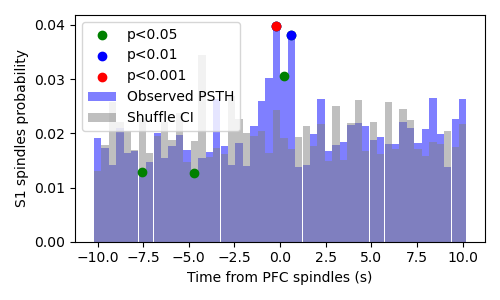

In [187]:
import numpy as np
import matplotlib.pyplot as plt
plt.close()

plt.figure(figsize=(5, 3))
# Simulate spike data
n_bins = bins
spike_counts=GrandPSTH_S1_PFCspdl

# Compute the observed PSTH
observed_psth = np.mean(spike_counts, axis=0)

# Monte Carlo parameters
n_permutations = 5000
shuffled_psths = []

# Shuffle data and compute shuffled PSTHs
for _ in range(n_permutations):
    shuffled_counts = np.apply_along_axis(np.random.permutation, 1, spike_counts)
    shuffled_psth = shuffled_counts.mean(axis=0)
    shuffled_psths.append(shuffled_psth)

shuffled_psths = np.array(shuffled_psths)

# Compute significance (e.g., p < 0.05)
alpha = 0.05
lower_bound = np.percentile(shuffled_psths, alpha / 2 * 100, axis=0)
upper_bound = np.percentile(shuffled_psths, (1 - alpha / 2) * 100, axis=0)
significant_bins05 = (observed_psth < lower_bound) | (observed_psth > upper_bound)

alpha = 0.01
lower_bound = np.percentile(shuffled_psths, alpha / 2 * 100, axis=0)
upper_bound = np.percentile(shuffled_psths, (1 - alpha / 2) * 100, axis=0)
significant_bins01 = (observed_psth < lower_bound) | (observed_psth > upper_bound)

alpha = 0.001
lower_bound = np.percentile(shuffled_psths, alpha / 2 * 100, axis=0)
upper_bound = np.percentile(shuffled_psths, (1 - alpha / 2) * 100, axis=0)
significant_bins001 = (observed_psth < lower_bound) | (observed_psth > upper_bound)


# Plot results
time_bins = np.linspace(-10, 10, n_bins)
plt.bar(time_bins, observed_psth, label='Observed PSTH', color='blue', width=0.4, alpha=0.5)
plt.bar(time_bins, shuffled_psths[0], color='gray', label='Shuffle CI', width=0.4, alpha=0.5)

plt.scatter(
    time_bins[significant_bins05],
    observed_psth[significant_bins05],
    color='green',
    label='p<0.05',
)
plt.scatter(
    time_bins[significant_bins01],
    observed_psth[significant_bins01],
    color='blue',
    label='p<0.01',
)
plt.scatter(
    time_bins[significant_bins001],
    observed_psth[significant_bins001],
    color='red',
    label='p<0.001',
)
plt.xlabel('Time from PFC spindles (s)')
plt.ylabel('S1 spindles probability')
plt.legend()
plt.tight_layout()
plt.savefig(f'C:/Users/Manip2/Documents/Manuscripts/Figures_PNASreviews/Figure4_revised/ProbaS1SpdlPFCSpdl.svg', format='svg', bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()
